# Moving Annual Rent Analysis

This notebook processes the moving annual rent Excel files to extract median rent data by suburb, property type, quarter, and year.

## Data Structure
- Each Excel file contains multiple sheets for different property types
- Property types: 1 bedroom flat, 2 bedroom flat, 3 bedroom flat, 2 bedroom house, 3 bedroom house, 4 bedroom house
- Each sheet has quarterly data (Mar, Jun, Sep, Dec) for multiple years
- Data includes both Count and Median columns for each quarter/year combination
- We will extract only the Median columns and restructure the data


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')


## Define Data Processing Functions


In [2]:
def process_excel_file(file_path):
    """
    Process a single Excel file and extract median rent data.
    
    Args:
        file_path (str): Path to the Excel file
    
    Returns:
        pd.DataFrame: Processed data with columns: suburb, property_type, quarter, year, median_rent
    """
    # Read all sheets from the Excel file
    all_sheets = pd.read_excel(file_path, sheet_name=None, header=None)
    
    # Property types we want to process (excluding 'All properties')
    property_types = ['1 bedroom flat', '2 bedroom flat', '3 bedroom flat', 
                     '2 bedroom house', '3 bedroom house', '4 bedroom house']
    
    all_data = []
    
    for sheet_name, df in all_sheets.items():
        if sheet_name not in property_types:
            continue
            
        print(f"Processing {sheet_name} from {os.path.basename(file_path)}")
        
        # Find the data start row (where suburbs begin)
        # Look for the first non-null value in the first column that's not a header
        data_start_row = None
        for i in range(len(df)):
            if pd.notna(df.iloc[i, 0]) and df.iloc[i, 0] not in ['Moving annual median rent by suburb', '1 bedroom flat', '2 bedroom flat', '3 bedroom flat', '2 bedroom house', '3 bedroom house', '4 bedroom house']:
                data_start_row = i
                break
        
        if data_start_row is None:
            print(f"Warning: Could not find data start row for {sheet_name}")
            continue
        
        # Extract suburb names (first column, starting from data_start_row)
        suburbs = df.iloc[data_start_row:, 0].dropna().tolist()
        
        # Process each quarter/year combination
        # The pattern is: every 2 columns starting from column 2
        # Column 2: Mar 2000, Column 4: Jun 2000, Column 6: Sep 2000, Column 8: Dec 2000, etc.
        
        col_idx = 2  # Start from column 2
        while col_idx < df.shape[1]:
            # Check if this column has a quarter/year header
            quarter_year = df.iloc[1, col_idx]  # Row 1 contains quarter/year
            
            if pd.isna(quarter_year) or 'Count' in str(quarter_year) or 'Median' in str(quarter_year):
                col_idx += 1
                continue
            
            # The median data is in the next column (col_idx + 1)
            median_col = col_idx + 1
            
            if median_col >= df.shape[1]:
                break
            
            # Parse quarter and year
            try:
                quarter, year = str(quarter_year).split()
                year = int(year)
            except:
                col_idx += 2
                continue
            
            # Extract median values for this quarter/year
            median_values = df.iloc[data_start_row:data_start_row + len(suburbs), median_col].values
            
            # Create data for this quarter/year
            for i, suburb in enumerate(suburbs):
                if i < len(median_values) and pd.notna(median_values[i]) and median_values[i] != '-':
                    try:
                        median_rent = float(median_values[i])
                        all_data.append({
                            'suburb': suburb,
                            'property_type': sheet_name,
                            'quarter': quarter,
                            'year': year,
                            'median_rent': median_rent
                        })
                    except (ValueError, TypeError):
                        # Skip invalid values
                        continue
            
            col_idx += 2  # Move to next quarter/year pair
    
    return pd.DataFrame(all_data)


In [3]:
def process_all_files(data_dir):
    """
    Process all Excel files in the specified directory.
    
    Args:
        data_dir (str): Directory containing Excel files
    
    Returns:
        pd.DataFrame: Combined data from all files
    """
    all_data = []
    
    # Get all Excel files in the directory
    excel_files = [f for f in os.listdir(data_dir) if f.endswith('.xlsx')]
    excel_files.sort()  # Process in chronological order
    
    print(f"Found {len(excel_files)} Excel files to process:")
    for file in excel_files:
        print(f"  - {file}")
    
    for file in excel_files:
        file_path = os.path.join(data_dir, file)
        try:
            file_data = process_excel_file(file_path)
            if not file_data.empty:
                all_data.append(file_data)
                print(f"Successfully processed {file}: {len(file_data)} records")
            else:
                print(f"Warning: No data extracted from {file}")
        except Exception as e:
            print(f"Error processing {file}: {str(e)}")
    
    if all_data:
        combined_data = pd.concat(all_data, ignore_index=True)
        return combined_data
    else:
        return pd.DataFrame()


## Process the Data


In [4]:
# Set the data directory
data_dir = '../data/landing/moving_annual_rent'

# Process all Excel files
print("Starting data processing...")
df = process_all_files(data_dir)

print(f"\nTotal records processed: {len(df)}")
print(f"Data shape: {df.shape}")
print(f"Columns: {list(df.columns)}")


Starting data processing...
Found 1 Excel files to process:
  - moving_annual_median_weekly_rent_by_suburb.xlsx
Processing 1 bedroom flat from moving_annual_median_weekly_rent_by_suburb.xlsx
Processing 2 bedroom flat from moving_annual_median_weekly_rent_by_suburb.xlsx
Processing 3 bedroom flat from moving_annual_median_weekly_rent_by_suburb.xlsx
Processing 2 bedroom house from moving_annual_median_weekly_rent_by_suburb.xlsx
Processing 3 bedroom house from moving_annual_median_weekly_rent_by_suburb.xlsx
Processing 4 bedroom house from moving_annual_median_weekly_rent_by_suburb.xlsx
Successfully processed moving_annual_median_weekly_rent_by_suburb.xlsx: 7030 records

Total records processed: 7030
Data shape: (7030, 5)
Columns: ['suburb', 'property_type', 'quarter', 'year', 'median_rent']


## Examine the Processed Data


In [5]:
# Display basic information about the dataset
print("Dataset Overview:")
print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
print(df.head(10))

print(f"\nData types:")
print(df.dtypes)

print(f"\nUnique property types: {df['property_type'].unique()}")
print(f"Unique quarters: {sorted(df['quarter'].unique())}")
print(f"Year range: {df['year'].min()} - {df['year'].max()}")
print(f"Number of unique suburbs: {df['suburb'].nunique()}")


Dataset Overview:
Shape: (7030, 5)

First few rows:
                    suburb   property_type quarter  year  median_rent
0          Inner Melbourne  1 bedroom flat     Mar  2000        165.0
1  Inner Eastern Melbourne  1 bedroom flat     Mar  2000        150.0
2       Southern Melbourne  1 bedroom flat     Mar  2000        150.0
3  Outer Western Melbourne  1 bedroom flat     Mar  2000        165.0
4  North Western Melbourne  1 bedroom flat     Mar  2000        250.0
5  North Eastern Melbourne  1 bedroom flat     Mar  2000        135.0
6  South Eastern Melbourne  1 bedroom flat     Mar  2000        180.0
7     Mornington Peninsula  1 bedroom flat     Mar  2000        140.0
8                  Geelong  1 bedroom flat     Mar  2000        150.0
9                 Ballarat  1 bedroom flat     Mar  2000        140.0

Data types:
suburb            object
property_type     object
quarter           object
year               int64
median_rent      float64
dtype: object

Unique property types: ['

In [6]:
# Check for missing values
print("Missing values:")
print(df.isnull().sum())

# Check data quality
print(f"\nData quality checks:")
print(f"Records with negative median rent: {(df['median_rent'] < 0).sum()}")
print(f"Records with zero median rent: {(df['median_rent'] == 0).sum()}")
print(f"Records with very high median rent (>$5000): {(df['median_rent'] > 5000).sum()}")


Missing values:
suburb           0
property_type    0
quarter          0
year             0
median_rent      0
dtype: int64

Data quality checks:
Records with negative median rent: 0
Records with zero median rent: 0
Records with very high median rent (>$5000): 0


## Create Pivot Table for Analysis


In [7]:
# Create a pivot table with quarters and years as columns
# First, create a combined quarter_year column
df['quarter_year'] = df['quarter'] + '_' + df['year'].astype(str)

# Create pivot table
pivot_df = df.pivot_table(
    index=['suburb', 'property_type'],
    columns='quarter_year',
    values='median_rent',
    aggfunc='first'  # In case there are duplicates
).reset_index()

print(f"Pivot table shape: {pivot_df.shape}")
print(f"\nFirst few rows:")
print(pivot_df.head())

print(f"\nColumn names (first 20):")
print(list(pivot_df.columns)[:20])


Pivot table shape: (73, 103)

First few rows:
quarter_year    suburb    property_type  Dec_2000  Dec_2001  Dec_2002  \
0             Ballarat   1 bedroom flat     150.0     163.0     180.0   
1             Ballarat   2 bedroom flat     290.0     300.0     300.0   
2             Ballarat  2 bedroom house     260.0     280.0     285.0   
3             Ballarat   3 bedroom flat     340.0     340.0     408.0   
4             Ballarat  3 bedroom house     348.0     350.0     360.0   

quarter_year  Dec_2003  Dec_2004  Dec_2005  Dec_2006  Dec_2007  ...  Sep_2015  \
0                185.0     185.0     190.0     205.0     240.0  ...     360.0   
1                320.0     320.0     325.0     360.0     380.0  ...     525.0   
2                290.0     300.0     320.0     350.0     390.0  ...     588.0   
3                383.0     450.0     450.0     545.0     480.0  ...     737.0   
4                385.0     380.0     380.0     398.0     440.0  ...     750.0   

quarter_year  Sep_2016  Sep_

## Data Summary and Statistics


In [8]:
# Summary statistics by property type
print("Summary statistics by property type:")
summary_stats = df.groupby('property_type')['median_rent'].agg(['count', 'mean', 'median', 'std', 'min', 'max']).round(2)
print(summary_stats)

# Summary by quarter
print("\nSummary statistics by quarter:")
quarter_stats = df.groupby('quarter')['median_rent'].agg(['count', 'mean', 'median', 'std']).round(2)
print(quarter_stats)

# Summary by year
print("\nSummary statistics by year:")
year_stats = df.groupby('year')['median_rent'].agg(['count', 'mean', 'median', 'std']).round(2)
print(year_stats)


Summary statistics by property type:
                 count    mean  median     std    min     max
property_type                                                
1 bedroom flat    1305  305.64   320.0   91.47  120.0   580.0
2 bedroom flat    1305  420.21   420.0  118.72  160.0   750.0
2 bedroom house   1076  480.34   499.0  141.17  220.0   875.0
3 bedroom flat    1303  594.95   595.0  190.20  250.0  1180.0
3 bedroom house   1096  638.94   650.0  213.94  260.0  1295.0
4 bedroom house    945  798.30   800.0  292.33  300.0  1723.0

Summary statistics by quarter:
         count    mean  median     std
quarter                               
Dec       1744  531.60   480.0  240.37
Jun       1736  519.61   470.0  235.58
Mar       1806  524.98   471.5  239.57
Sep       1744  525.63   475.0  237.54

Summary statistics by year:
      count    mean  median     std
year                               
2000    276  291.26   294.0  102.48
2001    272  309.43   300.0  103.23
2002    283  318.27   310.0 

## Save Processed Data


In [ ]:
# Save the long format data
output_file_long = '../data/processed/moving_rent/moving_annual_rent_long.csv'
os.makedirs(os.path.dirname(output_file_long), exist_ok=True)
df.to_csv(output_file_long, index=False)
print(f"Long format data saved to: {output_file_long}")

# Save the pivot table format
output_file_pivot = '../data/processed/moving_rent/moving_annual_rent_pivot.csv'
pivot_df.to_csv(output_file_pivot, index=False)
print(f"Pivot table data saved to: {output_file_pivot}")

print(f"\nData processing complete!")
print(f"Total records: {len(df)}")
print(f"Unique suburbs: {df['suburb'].nunique()}")
print(f"Property types: {len(df['property_type'].unique())}")
print(f"Time period: {df['year'].min()}-{df['year'].max()}")


Long format data saved to: ../data/processed/moving_annual_rent_long.csv
Pivot table data saved to: ../data/processed/moving_annual_rent_pivot.csv

Data processing complete!
Total records: 7030
Unique suburbs: 13
Property types: 6
Time period: 2000-2025


## Sample Data Exploration


In [10]:
# Look at data for a specific suburb
sample_suburb = df['suburb'].iloc[0]  # Get first suburb
print(f"Sample data for suburb: {sample_suburb}")
sample_data = df[df['suburb'] == sample_suburb].sort_values(['property_type', 'year', 'quarter'])
print(sample_data.head(20))

# Look at data for a specific property type
sample_property = '1 bedroom flat'
print(f"\nSample data for property type: {sample_property}")
property_data = df[df['property_type'] == sample_property].sort_values(['suburb', 'year', 'quarter'])
print(property_data.head(20))


Sample data for suburb: Inner Melbourne
              suburb   property_type quarter  year  median_rent quarter_year
36   Inner Melbourne  1 bedroom flat     Dec  2000        175.0     Dec_2000
12   Inner Melbourne  1 bedroom flat     Jun  2000        165.0     Jun_2000
0    Inner Melbourne  1 bedroom flat     Mar  2000        165.0     Mar_2000
24   Inner Melbourne  1 bedroom flat     Sep  2000        170.0     Sep_2000
84   Inner Melbourne  1 bedroom flat     Dec  2001        190.0     Dec_2001
60   Inner Melbourne  1 bedroom flat     Jun  2001        185.0     Jun_2001
48   Inner Melbourne  1 bedroom flat     Mar  2001        180.0     Mar_2001
72   Inner Melbourne  1 bedroom flat     Sep  2001        190.0     Sep_2001
135  Inner Melbourne  1 bedroom flat     Dec  2002        215.0     Dec_2002
109  Inner Melbourne  1 bedroom flat     Jun  2002        200.0     Jun_2002
96   Inner Melbourne  1 bedroom flat     Mar  2002        195.0     Mar_2002
122  Inner Melbourne  1 bedroom flat

# Preprocess Economic Time Series Data from RBA

In [11]:
# Set up paths
data_path = Path("../data/landing")

# Read all datasets
print("Reading datasets...")

# Price data
price_data = pd.read_csv(data_path / "price_data" / "quarterly_price_data.csv")
print(f"Price data shape: {price_data.shape}")

# Unemployment rate
unemployment_data = pd.read_csv(data_path / "unemployment_rate" / "quarterly_unemployment_rate.csv")
print(f"Unemployment data shape: {unemployment_data.shape}")

# Economic activity
economic_data = pd.read_csv(data_path / "economic_activity" / "quarterly_economic_activity.csv")
print(f"Economic activity data shape: {economic_data.shape}")

# Investment
investment_data = pd.read_csv(data_path / "investment" / "quarterly_investment.csv")
print(f"Investment data shape: {investment_data.shape}")

# Population
population_data = pd.read_csv(data_path / "population" / "quarterly_population_dynamics.csv")
print(f"Population data shape: {population_data.shape}")

# Interest rates
interest_data = pd.read_csv(data_path / "interest_rates" / "quarterly_interest_rates.csv")
print(f"Interest rates data shape: {interest_data.shape}")

print("\nDataset columns:")
print("Price data:", price_data.columns.tolist())
print("Unemployment data:", unemployment_data.columns.tolist())
print("Economic activity data:", economic_data.columns.tolist())
print("Investment data:", investment_data.columns.tolist())
print("Population data:", population_data.columns.tolist())
print("Interest rates data:", interest_data.columns.tolist())

Reading datasets...
Price data shape: (304, 6)
Unemployment data shape: (191, 4)
Economic activity data shape: (156, 5)
Investment data shape: (156, 8)
Population data shape: (172, 7)
Interest rates data shape: (183, 6)

Dataset columns:
Price data: ['date', 'year', 'quarter', 'CPI (%/y)', 'WPI (%/y)', 'PPI, Final Demand (%/y)']
Unemployment data: ['date', 'year', 'quarter', 'Unemployment rate (%)']
Economic activity data: ['date', 'year', 'quarter', 'SFD (%/y)', 'GSP quarterly components (%/y)']
Investment data: ['date', 'year', 'quarter', 'State final demand (%/y)', 'Household consumption (pp/y)', 'Dwelling investment (pp/y)', 'Business investment (pp/y)', 'Government spending (pp/y)']
Population data: ['date', 'year', 'quarter', 'Population (%/y)', 'Natural increase (pp/y)', 'Net overseas migration (pp/y)', 'Net interstate migration (pp/y)']
Interest rates data: ['date', 'year', 'quarter', 'Mortgage rates (%)', 'Savings rates (%)', 'Cash rate (%)']


In [12]:
# Merge all datasets on year and quarter
print("Merging datasets...")

# Start with price data as the base
merged_data = price_data.copy()

# Merge unemployment data
merged_data = merged_data.merge(
    unemployment_data[['year', 'quarter', 'Unemployment rate (%)']], 
    on=['year', 'quarter'], 
    how='outer'
)

# Merge economic activity data
merged_data = merged_data.merge(
    economic_data[['year', 'quarter', 'SFD (%/y)', 'GSP quarterly components (%/y)']], 
    on=['year', 'quarter'], 
    how='outer'
)

# Merge investment data
investment_cols = ['year', 'quarter', 'State final demand (%/y)', 'Household consumption (pp/y)', 
                  'Dwelling investment (pp/y)', 'Business investment (pp/y)', 'Government spending (pp/y)']
merged_data = merged_data.merge(
    investment_data[investment_cols], 
    on=['year', 'quarter'], 
    how='outer'
)

# Merge population data
population_cols = ['year', 'quarter', 'Population (%/y)', 'Natural increase (pp/y)', 
                  'Net overseas migration (pp/y)', 'Net interstate migration (pp/y)']
merged_data = merged_data.merge(
    population_data[population_cols], 
    on=['year', 'quarter'], 
    how='outer'
)

# Merge interest rates data
interest_cols = ['year', 'quarter', 'Mortgage rates (%)', 'Savings rates (%)', 'Cash rate (%)']
merged_data = merged_data.merge(
    interest_data[interest_cols], 
    on=['year', 'quarter'], 
    how='outer'
)

print(f"Merged dataset shape: {merged_data.shape}")
print(f"Merged dataset columns: {merged_data.columns.tolist()}")

# Sort by year and quarter
merged_data = merged_data.sort_values(['year', 'quarter']).reset_index(drop=True)

# Create a quarter identifier for plotting
merged_data['quarter_id'] = merged_data['year'].astype(str) + 'Q' + merged_data['quarter'].astype(str)

print(f"\nDate range: {merged_data['year'].min()}-{merged_data['quarter'].min()} to {merged_data['year'].max()}-{merged_data['quarter'].max()}")
print(f"Total quarters: {len(merged_data)}")

# Display first few rows
print("\nFirst 5 rows of merged data:")
print(merged_data.head())


Merging datasets...
Merged dataset shape: (345, 21)
Merged dataset columns: ['date', 'year', 'quarter', 'CPI (%/y)', 'WPI (%/y)', 'PPI, Final Demand (%/y)', 'Unemployment rate (%)', 'SFD (%/y)', 'GSP quarterly components (%/y)', 'State final demand (%/y)', 'Household consumption (pp/y)', 'Dwelling investment (pp/y)', 'Business investment (pp/y)', 'Government spending (pp/y)', 'Population (%/y)', 'Natural increase (pp/y)', 'Net overseas migration (pp/y)', 'Net interstate migration (pp/y)', 'Mortgage rates (%)', 'Savings rates (%)', 'Cash rate (%)']

Date range: 1949-1 to 2035-4
Total quarters: 345

First 5 rows of merged data:
         date  year  quarter  CPI (%/y)  WPI (%/y)  PPI, Final Demand (%/y)  \
0  1949-09-01  1949        3        7.9        NaN                      NaN   
1  1949-12-01  1949        4       10.5        NaN                      NaN   
2  1950-03-01  1950        1       10.3        NaN                      NaN   
3  1950-06-01  1950        2       10.0        NaN

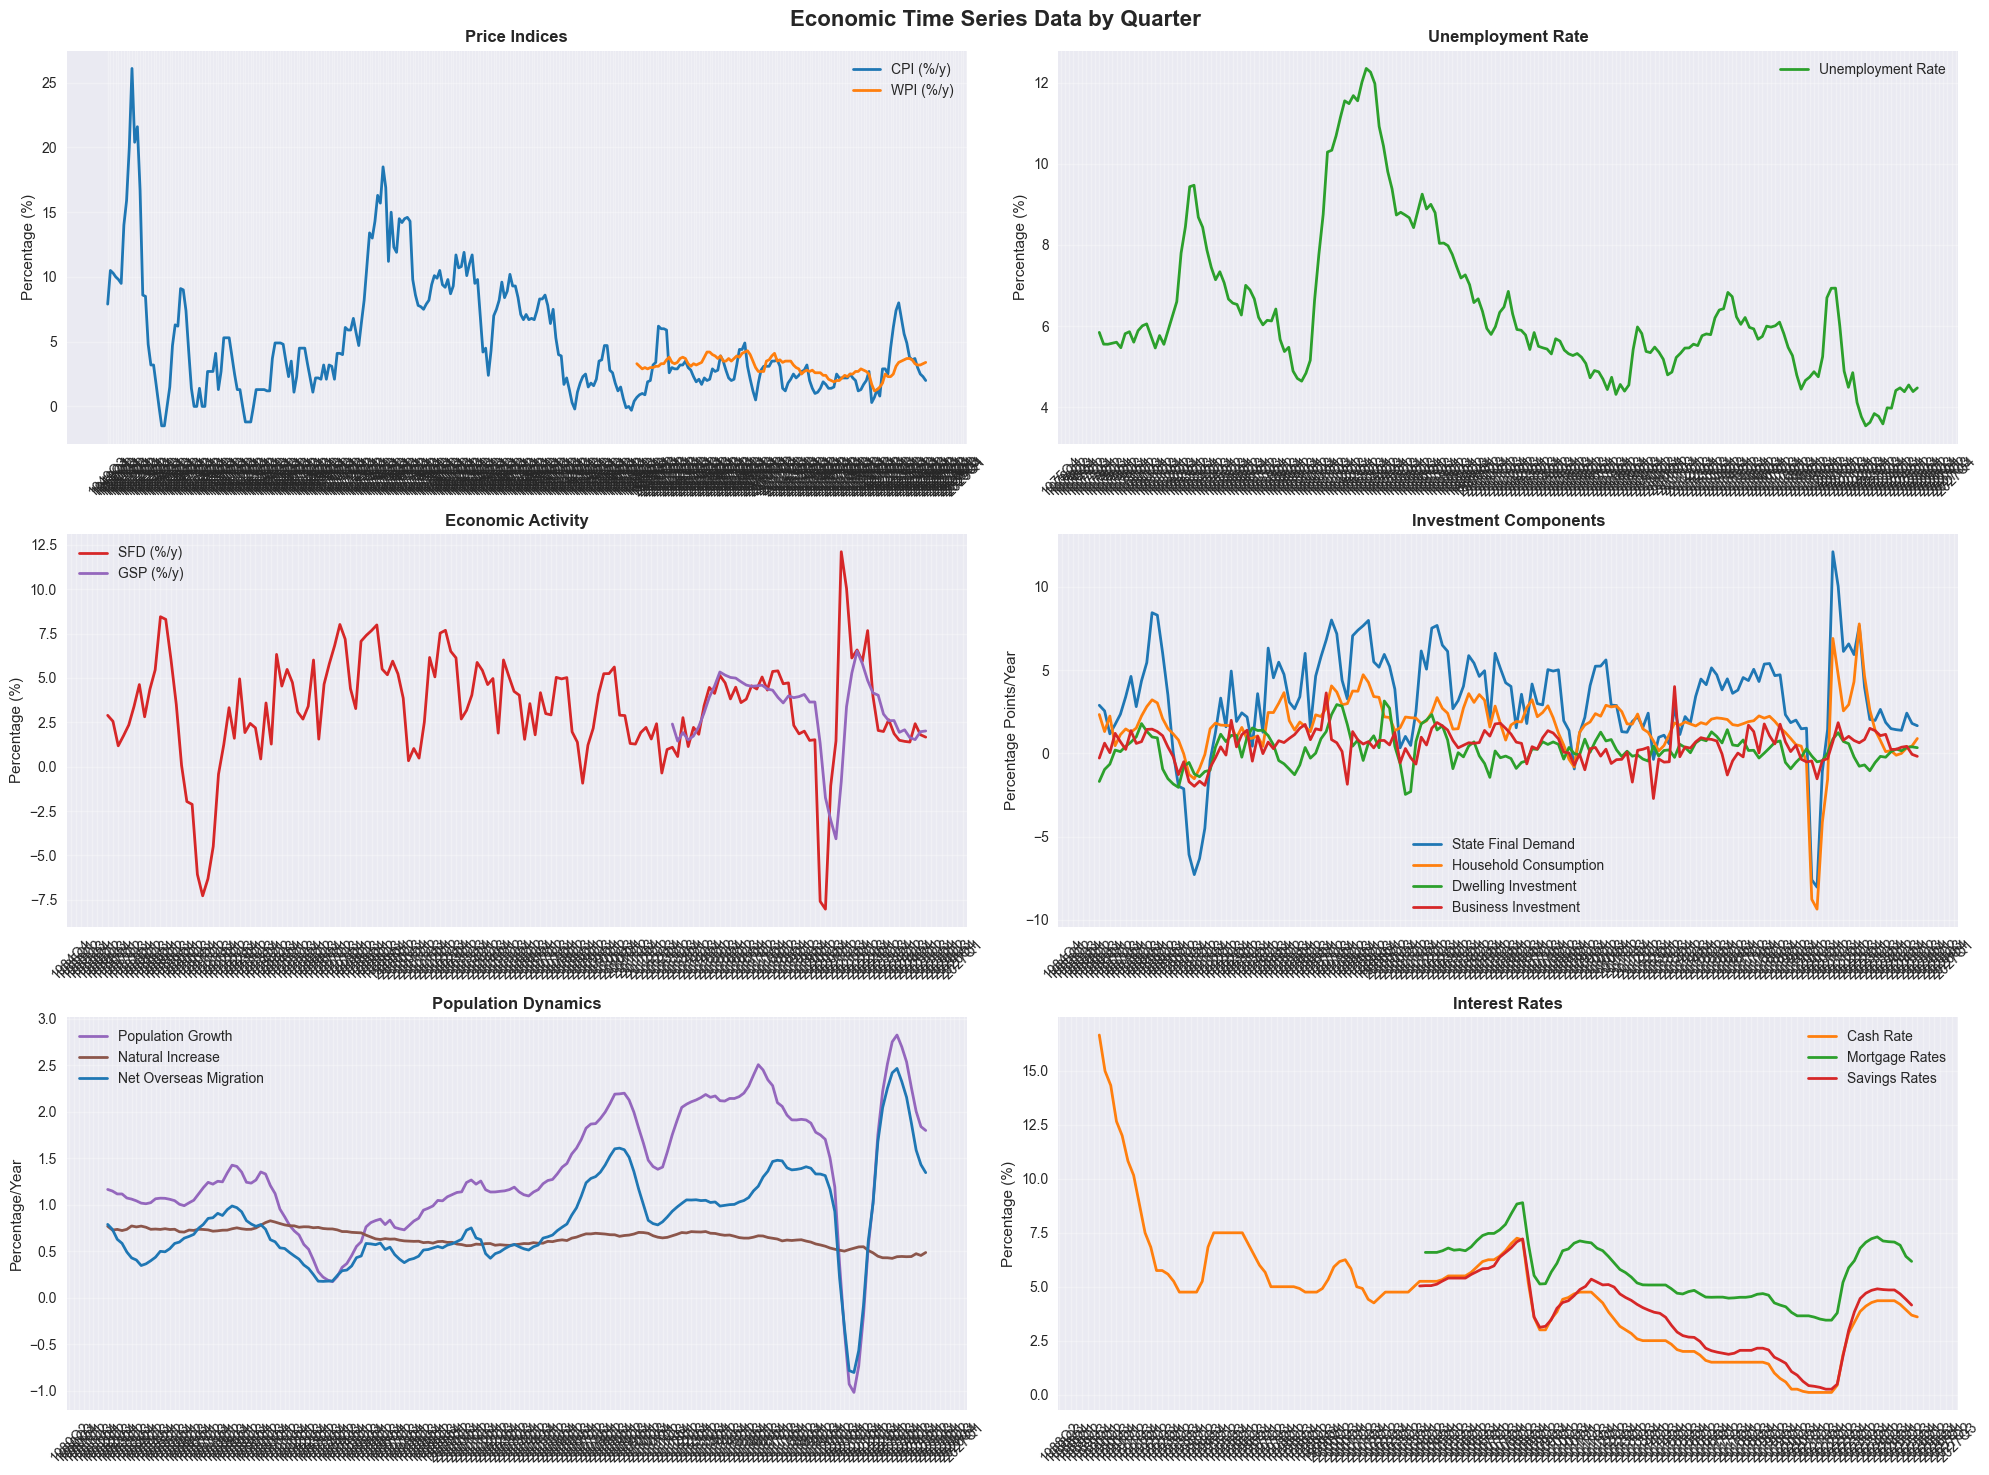


Summary Statistics for Key Variables:

CPI (%/y):
  Mean: 4.92
  Std:  4.41
  Min:  -1.50
  Max:  26.10

Unemployment rate (%):
  Mean: 6.41
  Std:  1.91
  Min:  3.54
  Max:  12.36

SFD (%/y):
  Mean: 3.25
  Std:  3.06
  Min:  -8.03
  Max:  12.12

Population (%/y):
  Mean: 1.33
  Std:  0.68
  Min:  -1.02
  Max:  2.82

Cash rate (%):
  Mean: 4.58
  Std:  2.81
  Min:  0.10
  Max:  16.67


In [13]:
# Create time series plots
plt.style.use('seaborn-v0_8')
fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.suptitle('Economic Time Series Data by Quarter', fontsize=16, fontweight='bold')

# Define colors for consistency
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']

# Plot 1: Price Data
ax1 = axes[0, 0]
ax1.plot(merged_data['quarter_id'], merged_data['CPI (%/y)'], label='CPI (%/y)', color=colors[0], linewidth=2)
ax1.plot(merged_data['quarter_id'], merged_data['WPI (%/y)'], label='WPI (%/y)', color=colors[1], linewidth=2)
ax1.set_title('Price Indices', fontweight='bold')
ax1.set_ylabel('Percentage (%)')
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.tick_params(axis='x', rotation=45)

# Plot 2: Unemployment Rate
ax2 = axes[0, 1]
ax2.plot(merged_data['quarter_id'], merged_data['Unemployment rate (%)'], 
         color=colors[2], linewidth=2, label='Unemployment Rate')
ax2.set_title('Unemployment Rate', fontweight='bold')
ax2.set_ylabel('Percentage (%)')
ax2.legend()
ax2.grid(True, alpha=0.3)
ax2.tick_params(axis='x', rotation=45)

# Plot 3: Economic Activity
ax3 = axes[1, 0]
ax3.plot(merged_data['quarter_id'], merged_data['SFD (%/y)'], 
         color=colors[3], linewidth=2, label='SFD (%/y)')
ax3.plot(merged_data['quarter_id'], merged_data['GSP quarterly components (%/y)'], 
         color=colors[4], linewidth=2, label='GSP (%/y)')
ax3.set_title('Economic Activity', fontweight='bold')
ax3.set_ylabel('Percentage (%)')
ax3.legend()
ax3.grid(True, alpha=0.3)
ax3.tick_params(axis='x', rotation=45)

# Plot 4: Investment Components
ax4 = axes[1, 1]
ax4.plot(merged_data['quarter_id'], merged_data['State final demand (%/y)'], 
         color=colors[0], linewidth=2, label='State Final Demand')
ax4.plot(merged_data['quarter_id'], merged_data['Household consumption (pp/y)'], 
         color=colors[1], linewidth=2, label='Household Consumption')
ax4.plot(merged_data['quarter_id'], merged_data['Dwelling investment (pp/y)'], 
         color=colors[2], linewidth=2, label='Dwelling Investment')
ax4.plot(merged_data['quarter_id'], merged_data['Business investment (pp/y)'], 
         color=colors[3], linewidth=2, label='Business Investment')
ax4.set_title('Investment Components', fontweight='bold')
ax4.set_ylabel('Percentage Points/Year')
ax4.legend()
ax4.grid(True, alpha=0.3)
ax4.tick_params(axis='x', rotation=45)

# Plot 5: Population Dynamics
ax5 = axes[2, 0]
ax5.plot(merged_data['quarter_id'], merged_data['Population (%/y)'], 
         color=colors[4], linewidth=2, label='Population Growth')
ax5.plot(merged_data['quarter_id'], merged_data['Natural increase (pp/y)'], 
         color=colors[5], linewidth=2, label='Natural Increase')
ax5.plot(merged_data['quarter_id'], merged_data['Net overseas migration (pp/y)'], 
         color=colors[0], linewidth=2, label='Net Overseas Migration')
ax5.set_title('Population Dynamics', fontweight='bold')
ax5.set_ylabel('Percentage/Year')
ax5.legend()
ax5.grid(True, alpha=0.3)
ax5.tick_params(axis='x', rotation=45)

# Plot 6: Interest Rates
ax6 = axes[2, 1]
ax6.plot(merged_data['quarter_id'], merged_data['Cash rate (%)'], 
         color=colors[1], linewidth=2, label='Cash Rate')
ax6.plot(merged_data['quarter_id'], merged_data['Mortgage rates (%)'], 
         color=colors[2], linewidth=2, label='Mortgage Rates')
ax6.plot(merged_data['quarter_id'], merged_data['Savings rates (%)'], 
         color=colors[3], linewidth=2, label='Savings Rates')
ax6.set_title('Interest Rates', fontweight='bold')
ax6.set_ylabel('Percentage (%)')
ax6.legend()
ax6.grid(True, alpha=0.3)
ax6.tick_params(axis='x', rotation=45)

# Adjust layout and show
plt.tight_layout()
plt.show()

# Print summary statistics
print("\nSummary Statistics for Key Variables:")
print("="*50)
key_vars = ['CPI (%/y)', 'Unemployment rate (%)', 'SFD (%/y)', 'Population (%/y)', 'Cash rate (%)']
for var in key_vars:
    if var in merged_data.columns:
        print(f"\n{var}:")
        print(f"  Mean: {merged_data[var].mean():.2f}")
        print(f"  Std:  {merged_data[var].std():.2f}")
        print(f"  Min:  {merged_data[var].min():.2f}")
        print(f"  Max:  {merged_data[var].max():.2f}")


In [14]:
# Save the merged dataset
# create rent_growth folder if it doesn't exist
if not os.path.exists("../data/curated/rent_growth"):
    os.makedirs("../data/curated/rent_growth")

output_path = "../data/curated/rent_growth/economic_time_series.csv"
merged_data.to_csv(output_path, index=False)
print(f"\nMerged dataset saved to: {output_path}")

# Display data quality information
print("\nData Quality Information:")
print("="*40)
print(f"Total rows: {len(merged_data)}")
print(f"Total columns: {len(merged_data.columns)}")

# Check for missing values
missing_data = merged_data.isnull().sum()
print(f"\nMissing values by column:")
for col in missing_data[missing_data > 0].index:
    print(f"  {col}: {missing_data[col]} ({missing_data[col]/len(merged_data)*100:.1f}%)")

# Check date coverage
print(f"\nDate coverage:")
print(f"  Start: {merged_data['year'].min()}-Q{merged_data['quarter'].min()}")
print(f"  End: {merged_data['year'].max()}-Q{merged_data['quarter'].max()}")
print(f"  Total quarters: {len(merged_data)}")

# Show sample of the merged data
print(f"\nSample of merged data (first 3 rows):")
print(merged_data[['year', 'quarter', 'quarter_id', 'CPI (%/y)', 'Unemployment rate (%)', 'Cash rate (%)']].head(3))



Merged dataset saved to: ../data/curated/rent_growth/economic_time_series.csv

Data Quality Information:
Total rows: 345
Total columns: 22

Missing values by column:
  date: 41 (11.9%)
  CPI (%/y): 41 (11.9%)
  WPI (%/y): 237 (68.7%)
  PPI, Final Demand (%/y): 241 (69.9%)
  Unemployment rate (%): 154 (44.6%)
  SFD (%/y): 189 (54.8%)
  GSP quarterly components (%/y): 296 (85.8%)
  State final demand (%/y): 189 (54.8%)
  Household consumption (pp/y): 189 (54.8%)
  Dwelling investment (pp/y): 189 (54.8%)
  Business investment (pp/y): 189 (54.8%)
  Government spending (pp/y): 189 (54.8%)
  Population (%/y): 173 (50.1%)
  Natural increase (pp/y): 173 (50.1%)
  Net overseas migration (pp/y): 173 (50.1%)
  Net interstate migration (pp/y): 173 (50.1%)
  Mortgage rates (%): 259 (75.1%)
  Savings rates (%): 258 (74.8%)
  Cash rate (%): 201 (58.3%)

Date coverage:
  Start: 1949-Q1
  End: 2035-Q4
  Total quarters: 345

Sample of merged data (first 3 rows):
   year  quarter quarter_id  CPI (%/y)  

In [15]:
merged_data

,date,year,quarter,CPI (%/y),WPI (%/y),"PPI, Final Demand (%/y)",Unemployment rate (%),SFD (%/y),GSP quarterly components (%/y),State final demand (%/y),...,Business investment (pp/y),Government spending (pp/y),Population (%/y),Natural increase (pp/y),Net overseas migration (pp/y),Net interstate migration (pp/y),Mortgage rates (%),Savings rates (%),Cash rate (%),quarter_id
0,1949-09-01,1949,3,7.9,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949Q3
1,1949-12-01,1949,4,10.5,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1949Q4
2,1950-03-01,1950,1,10.3,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950Q1
3,1950-06-01,1950,2,10.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950Q2
4,1950-09-01,1950,3,9.8,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950Q3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
340,NaN,2034,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2034Q3
341,NaN,2034,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2034Q4
342,NaN,2035,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035Q1
343,NaN,2035,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2035Q2


## Merge in suburb moving annual median rent time series data

In [16]:
# read in moving_annual_rent_long from data/processed/moving_rent 
df_rent = pd.read_csv('../data/processed/moving_rent/moving_annual_rent_pivot.csv')

# merge df_rent and merged_data on year, quarter
merged_data = merged_data.merge(df_rent, on=['year', 'quarter'], how='left')

# sort the dataframe by year, quarter
merged_data = merged_data.sort_values(['year', 'quarter'])




In [17]:
merged_data.columns


Index(['date', 'year', 'quarter', 'CPI (%/y)', 'WPI (%/y)',
       'PPI, Final Demand (%/y)', 'Unemployment rate (%)', 'SFD (%/y)',
       'GSP quarterly components (%/y)', 'State final demand (%/y)',
       'Household consumption (pp/y)', 'Dwelling investment (pp/y)',
       'Business investment (pp/y)', 'Government spending (pp/y)',
       'Population (%/y)', 'Natural increase (pp/y)',
       'Net overseas migration (pp/y)', 'Net interstate migration (pp/y)',
       'Mortgage rates (%)', 'Savings rates (%)', 'Cash rate (%)',
       'quarter_id', 'suburb', 'property_type', 'median_rent'],
      dtype='object')

In [18]:
# change column naming 
col_names = [
    'date', 'year', 'quarter', 
    'cpi', 'wpi', 'ppi', 
    'unemployment_rate', 'sfd', 'gsp', 'state_final_demand', 
    'household_consumption', 'dwelling_investment', 'business_investment', 'government_spending', 
    'population', 'natural_increase', 'net_overseas_migration', 'net_interstate_migration', 
    'mortgage_rates', 'savings_rates', 'cash_rate', 'quarter_id', 'suburb', 'property_type', 'median_rent'
]

# rename the columns
merged_data.columns = col_names

# drop quarter id
merged_data = merged_data.drop(columns=['quarter_id'])

# convert date to datetime
merged_data['date'] = pd.to_datetime(merged_data['date'])

In [19]:
# drop rows where suburb is null 
merged_data = merged_data[merged_data['suburb'].notna()]

In [20]:
# save the merged data
# create rent_growth folder if it doesn't exist
if not os.path.exists("../data/curated/rent_growth"):
    os.makedirs("../data/curated/rent_growth")

# save the merged data
merged_data.to_csv('../data/curated/rent_growth/panel_data.csv', index=False)


In [21]:
merged_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 84729 entries, 202 to 84930
Data columns (total 24 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   date                      84729 non-null  datetime64[ns]
 1   year                      84729 non-null  int64         
 2   quarter                   84729 non-null  int64         
 3   cpi                       84729 non-null  float64       
 4   wpi                       84729 non-null  float64       
 5   ppi                       84729 non-null  float64       
 6   unemployment_rate         84729 non-null  float64       
 7   sfd                       84729 non-null  float64       
 8   gsp                       40622 non-null  float64       
 9   state_final_demand        84729 non-null  float64       
 10  household_consumption     84729 non-null  float64       
 11  dwelling_investment       84729 non-null  float64       
 12  business_investment  